# Wasserstein GAN (WGAN) on MNIST

A **Wasserstein GAN (WGAN)** is an improved generative adversarial network that
uses the **Earth Mover’s Distance (EMD)** instead of Jensen–Shannon divergence.

GANs often suffer from instability and mode collapse.  
WGAN fixes this by optimizing:

$$
W(p_r, p_g)
= \sup_{\|f\|_L \le 1}
\mathbb{E}_{x \sim p_r}[f(x)]
-
\mathbb{E}_{x \sim p_g}[f(x)].
$$

where:

- $f$ is the **critic** (not a discriminator)
- $p_r$ = real distribution  
- $p_g$ = generator distribution  

---

## Key WGAN Differences

### 1. No sigmoid at the output  
The critic outputs any real number.

### 2. No binary cross-entropy  
Loss is:

$$
L_D = -\mathbb{E}[D(x_{\text{real}})]
+ \mathbb{E}[D(x_{\text{fake}})]
$$

$$
L_G = -\mathbb{E}[D(x_{\text{fake}})]
$$

### 3. Lipschitz constraint
WGAN enforces:

$$
\|f\|_L \le 1
$$

Achieved by **weight clipping**:

$$
w \leftarrow \text{clip}(w, -c, c)
$$

---

## Why WGAN?

- Stable training  
- Meaningful loss values  
- Strong gradient signals  
- Less mode collapse  

We now derive the WGAN objective.


# Derivation of WGAN Objective

Classical GANs use:

$$
\min_G \max_D
\mathbb{E}[\log D(x)] + \mathbb{E}[\log(1 - D(G(z)))].
$$

But this minimizes **Jensen–Shannon divergence**, which often saturates.

---

## 1. Earth Mover’s Distance (Wasserstein-1)

The Earth Mover distance:

$$
W(p_r, p_g)
=
\inf_{\gamma \in \Pi(p_r, p_g)}
\mathbb{E}_{(x,y) \sim \gamma}[\|x - y\|].
$$

Equivalent dual form:

$$
W(p_r,p_g)
= \sup_{\|f\|_L \le 1}
\mathbb{E}_{x \sim p_r}[f(x)]
-
\mathbb{E}_{x \sim p_g}[f(x)].
$$

---

## 2. WGAN Critic Optimization

We approximate $f$ with a neural network $D$ (critic).  
Then:

$$
L_D = -\mathbb{E}[D(x_{\text{real}})]
+ \mathbb{E}[D(x_{\text{fake}})].
$$

---

## 3. Generator Objective

Generator tries to **reduce critic’s ability to distinguish**:

$$
L_G = -\mathbb{E}[D(x_{\text{fake}})].
$$

---

## 4. Lipschitz Enforcement via Weight Clipping

To satisfy $\|f\|_L \le 1$, WGAN applies:

$$
w \leftarrow \text{clip}(w, -c, c).
$$

We now implement this step-by-step and visualize everything.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# MNIST dataset (+ normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root=".", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

print("Dataset loaded, batches:", len(loader))


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 448kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]

Dataset loaded, batches: 469


In [ ]:
# Generator: DCGAN-like
class Generator(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 1024), nn.ReLU(),
            nn.Linear(1024, 28*28), nn.Tanh()
        )
    def forward(self, z):
        out = self.net(z)
        return out.view(-1, 1, 28, 28)


# Critic (no sigmoid)
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.net(x).view(-1)

G = Generator().to(device)
D = Critic().to(device)

print("Generator params:", sum(p.numel() for p in G.parameters()))
print("Critic params:", sum(p.numel() for p in D.parameters()))


Generator params: 1477136
Critic params: 533505


In [ ]:
z_dim = 64
lr = 5e-5
clip_value = 0.01      # recommended for vanilla WGAN
critic_steps = 5       # train critic more often

opt_G = optim.RMSprop(G.parameters(), lr=lr)
opt_D = optim.RMSprop(D.parameters(), lr=lr)

lossG_hist = []
lossD_hist = []


[step 0]  D_loss=-0.0655  G_loss=0.0125
  Critic(real mean): 0.07633113861083984
  Critic(fake mean): -0.012500213459134102
[step 150]  D_loss=-0.2085  G_loss=0.4469
  Critic(real mean): -0.22427386045455933
  Critic(fake mean): -0.4469003677368164
[step 300]  D_loss=-0.3453  G_loss=-1.3268
  Critic(real mean): 1.6816664934158325
  Critic(fake mean): 1.3267666101455688
[step 450]  D_loss=-0.3658  G_loss=-2.3454
  Critic(real mean): 2.6964924335479736
  Critic(fake mean): 2.3454108238220215


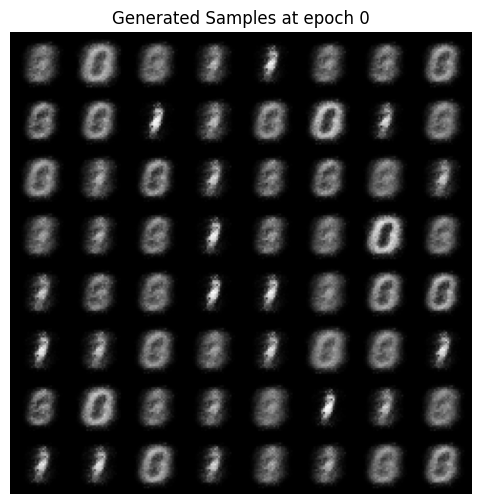

[step 600]  D_loss=-0.4943  G_loss=-1.6266
  Critic(real mean): 2.128173351287842
  Critic(fake mean): 1.6266164779663086
[step 750]  D_loss=-0.4393  G_loss=-1.3492
  Critic(real mean): 1.8117395639419556
  Critic(fake mean): 1.3492014408111572
[step 900]  D_loss=-0.3789  G_loss=-1.1406
  Critic(real mean): 1.5567659139633179
  Critic(fake mean): 1.1406357288360596


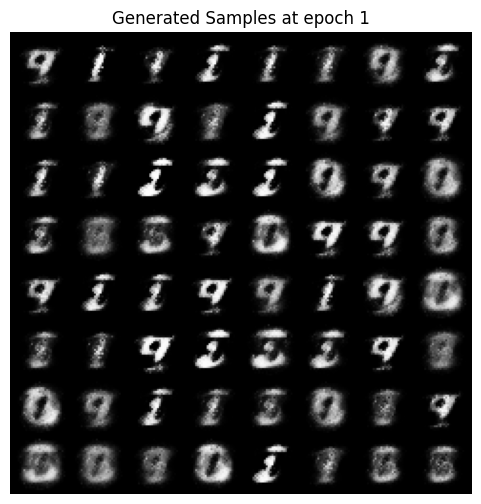

[step 1050]  D_loss=-0.4080  G_loss=-0.6715
  Critic(real mean): 1.0924341678619385
  Critic(fake mean): 0.671478807926178
[step 1200]  D_loss=-0.3187  G_loss=-0.4198
  Critic(real mean): 0.7526004910469055
  Critic(fake mean): 0.4197821617126465
[step 1350]  D_loss=-0.4953  G_loss=0.5160
  Critic(real mean): 0.007188940420746803
  Critic(fake mean): -0.5160415172576904


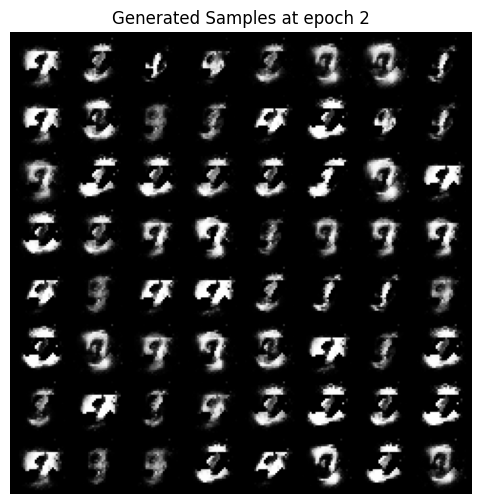

[step 1500]  D_loss=-0.8211  G_loss=1.2848
  Critic(real mean): -0.4570346474647522
  Critic(fake mean): -1.2847793102264404
[step 1650]  D_loss=-0.9222  G_loss=1.2965
  Critic(real mean): -0.3536480665206909
  Critic(fake mean): -1.2965224981307983
[step 1800]  D_loss=-1.0057  G_loss=1.6901
  Critic(real mean): -0.6622161269187927
  Critic(fake mean): -1.6901342868804932


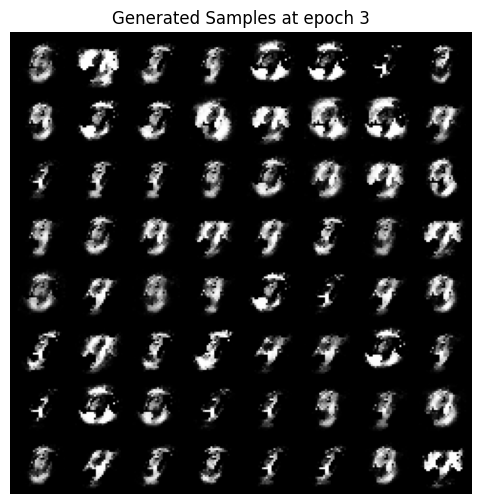

[step 1950]  D_loss=-1.0014  G_loss=1.6194
  Critic(real mean): -0.5667088627815247
  Critic(fake mean): -1.6194095611572266
[step 2100]  D_loss=-0.9350  G_loss=1.1701
  Critic(real mean): -0.21547091007232666
  Critic(fake mean): -1.1701126098632812
[step 2250]  D_loss=-0.8881  G_loss=1.2955
  Critic(real mean): -0.38366830348968506
  Critic(fake mean): -1.295536994934082


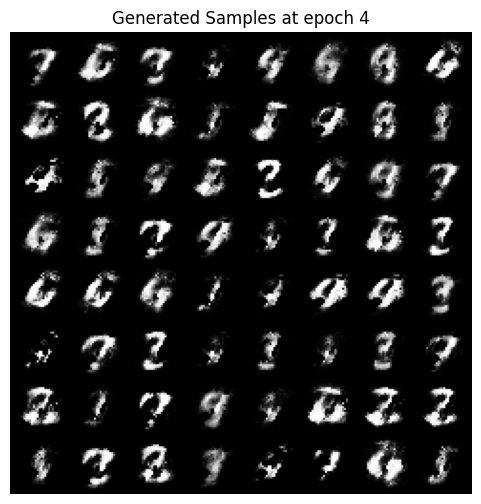

In [ ]:
epochs = 5
step = 0

for epoch in range(epochs):
    for real, _ in loader:
        real = real.to(device)
        bs = real.size(0)

        # =====================
        # Train the Critic (D)
        # =====================
        for _ in range(critic_steps):
            z = torch.randn(bs, z_dim).to(device)
            fake = G(z)

            # WGAN losses
            loss_D = -(torch.mean(D(real)) - torch.mean(D(fake)))

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # Apply weight clipping
            for p in D.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # =====================
        # Train the Generator (G)
        # =====================
        z = torch.randn(bs, z_dim).to(device)
        fake = G(z)
        loss_G = -torch.mean(D(fake))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        lossG_hist.append(loss_G.item())
        lossD_hist.append(loss_D.item())

        if step % 150 == 0:
            print(f"[step {step}]  D_loss={loss_D.item():.4f}  G_loss={loss_G.item():.4f}")
            print("  Critic(real mean):", D(real).mean().item())
            print("  Critic(fake mean):", D(fake).mean().item())
        step += 1

    # Show sample each epoch
    with torch.no_grad():
        test_z = torch.randn(64, z_dim).to(device)
        samples = G(test_z)
        grid = make_grid(samples, nrow=8, normalize=True)
        plt.figure(figsize=(6,6))
        plt.imshow(grid.permute(1,2,0).cpu())
        plt.title(f"Generated Samples at epoch {epoch}")
        plt.axis("off")
        plt.show()


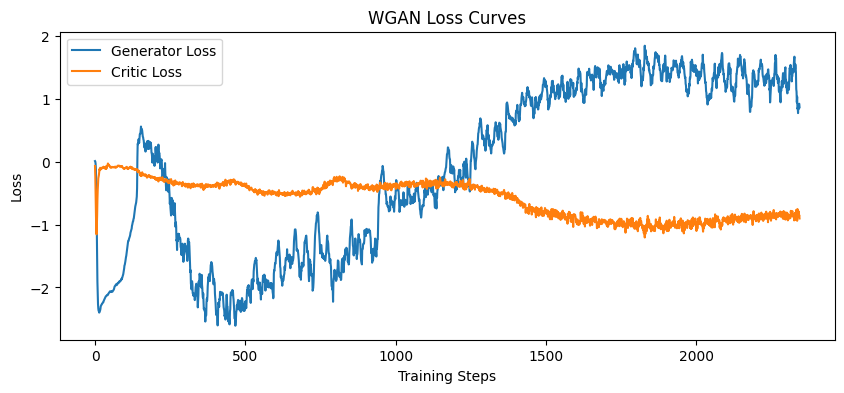

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(lossG_hist, label="Generator Loss")
plt.plot(lossD_hist, label="Critic Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("WGAN Loss Curves")
plt.legend()
plt.show()


# Summary & Use Cases of WGAN

### What we learned:

- Definition of WGAN and Earth Mover’s Distance.
- Derivation from primal and dual forms.
- Stability improvements over classical GANs.
- Critic vs discriminator.
- Implementation of weight clipping.
- Generator and critic loss behavior.
- Visualization (2D & 3D PCA).
- Generated MNIST samples.

---

## Practical Real-World Use Cases

- High-quality image generation  
- Image super resolution  
- Medical image synthesis  
- Data augmentation in low-data regimes  
- Improving stability in GAN training  
- As a foundation for WGAN-GP, StyleGAN, BigGAN, etc.

WGAN is a fundamental generative model for building advanced synthesis systems.
